<a href="https://colab.research.google.com/github/jtrinquier/SWAMPNN_/blob/main/colab_notebooks/ENCODE_ALIGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explains how to align proteins using SWAMPNN.
The file containing the pairs has to be in this format: 


```
name_of_protein_1\tchain_1\tname_of_protein_2_\t_chain2
```


Example

```
2A0B	A	2A0B	A
2A0B	A	3IQT	A
2A0B	A	4G78	A
2A0B	A	2OOC	A
3A02	A	3A02	A
```



In [1]:
! git clone https://github.com/jtrinquier/SWAMPNN_.git

Cloning into 'SWAMPNN_'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 140 (delta 11), reused 129 (delta 4), pack-reused 0
Receiving objects: 100% (140/140), 32.97 MiB | 20.00 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [2]:
import pandas as pd
!  pip install git+https://github.com/deepmind/dm-haiku
import numpy as np
import string
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax.example_libraries.optimizers import adam
from jax.example_libraries.optimizers import sgd
import haiku as hk
import os
import re
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-ev2bifeg
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-ev2bifeg
  Resolved https://github.com/deepmind/dm-haiku to commit 8807359cf0460856f27a314a1173ba8e30c360f3
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.10.dev0-py3-none-any.whl size=357665 sha256=6b9e43f39ab37adf2f09153876bfbc55d3ead49e821e66d0f98496d76cd5cc27
  Stored in directory: /tmp/pip-ephem-wheel-cache-8bz_zyfe/wheels/c7/4d/89/b159f184ad7c9e95672c342eafcc176ad92ee0c77f27f3bd23
Successfully built dm-haiku


In [3]:
import sys
sys.path.append('/content/SWAMPNN_')
import SW as SW
import LDDT_LOSS as lddt
import MPNN as MPNN
import Input_MPNN
import ENCODING as encode

# Get encoding


In [4]:
#@title Padding
def pad_(dicti_inputs,max):
  X1 = np.zeros((len(dicti_inputs),max,4,3))
  mask1 = np.zeros((len(dicti_inputs),max))
  res1 = -100*np.ones((len(dicti_inputs),max))
  chain1 = np.zeros((len(dicti_inputs),max))
  l1= []

  #for i in range(len(dicti_inputs)):
  for l,i in enumerate(dicti_inputs.keys()):
    taill1 = len(dicti_inputs[i][0][0,:])
    l1.append(taill1)
    X1[l,:taill1,:,:] = dicti_inputs[i][0]
    mask1[l,:taill1] = dicti_inputs[i][1]
    res1[l,:taill1] = dicti_inputs[i][3]
    chain1[l,:taill1] = dicti_inputs[i][2]

  return (X1,mask1,res1,chain1),l1


In [5]:
#@title Input
path_list_pairs = "/content/SWAMPNN_/pdb_list_example" #@param {type:"string"}

list_pairs = pd.read_csv(path_list_pairs,sep = "\t",header = None)
list_pdb = np.concatenate(np.array([list_pairs[0]+list_pairs[1],list_pairs[2]+list_pairs[3]]))

In [6]:
#@title ProteinMPNN input
pdb_path = "/content/SWAMPNN_/pdb/" #@param {type:"string"}
# Create the input for ProteinMPNN, this can take some time
print(f"Number of proteins: {len(np.unique(np.array(list_pdb)))}")
dicti_inputs = {}
for l,k in enumerate(np.unique(np.array(list_pdb))):
  #print(l,k)
  try:
    dicti_inputs[k] = Input_MPNN.get_inputs_mpnn(pdb_path+k[:-1],chain = k[-1])
    if l%100 == 0:
      print(l)
  except:
    print("wrong format")

Number of proteins: 100
0


In [7]:
siz_max = np.max(np.array([len(dicti_inputs[k][0][0,:]) for k in dicti_inputs.keys()]))
siz_max

297

In [24]:
input_data,len_ = pad_(dicti_inputs,siz_max)
X1,mask1,res1,ch1 = input_data

In [25]:
#@title Define Model and encode structures
num_layers = 3 #@param {type:"integer"}
num_neighbors = 64 #@param {type:"integer"}
encoding_dim = 64 #@param {type:"integer"}
categorical = False #@param {type:"boolean"}
nb_clusters = 0 #@param {type:"integer"}
batch_size = 25 #@param {type:"integer"}
params_path = "/content/SWAMPNN_/models/TM_ENDTOEND_3LAYER_64_FEATURES_CELOSS" #@param {type:"string"}


def encoding(x1,node_features = encoding_dim,
                 edge_features = encoding_dim, hidden_dim = encoding_dim,
                 num_encoder_layers=3,
                  k_neighbors=num_neighbors,categorical = categorical,nb_clusters = nb_clusters):
  if categorical:
    a = encode.ENCODING_KMEANS(node_features,edge_features,hidden_dim,num_encoder_layers,k_neighbors,nb_clusters = nb_clusters)
  else:
     a = encode.ENCODING(node_features,edge_features,hidden_dim,num_encoder_layers,k_neighbors)
  return a(x1)


ENCO = hk.transform(encoding) 
key = jax.random.PRNGKey(0)

@jax.jit
def get_encoding(weigths,input_data):
  return ENCO.apply(weigths,key,input_data)

params = pickle.load(open(params_path,'rb'))
enco = []
seqs = []
for k in range(len(X1)//batch_size):
  print(k)
  input_ = X1[batch_size*k:batch_size*(k+1)],mask1[batch_size*k:batch_size*(k+1)],res1[batch_size*k:batch_size*(k+1)],ch1[batch_size*k:batch_size*(k+1)]
  if categorical:
    enco_,seqs_ = get_encoding(params,input_)
  else:
    enco_ = get_encoding(params,input_)

  for l in range(len(enco_)):
    enco.append(enco_[l])
    if categorical:
      seqs.append(seqs_[l])

input_ = X1[-batch_size:],mask1[-batch_size:],res1[-batch_size:],ch1[-batch_size:]
if categorical:
  enco_,seqs_ = get_encoding(params,input_)
else:
  enco_= get_encoding(params,input_)

for l in range(len(enco_)-len(X1)%batch_size,len(enco_)):
  enco.append(enco_[l])
  if categorical:
    seqs.append(seqs_[l])



0
1
2
3


In [26]:
dicti_enco = {}
dicti_seqs = {}
dicti_len = {}
for l,k in enumerate(np.unique(np.array(list_pdb))):
  #print(l,k)
  dicti_enco[k] = enco[l]
  dicti_len[k] = len_[l]
  if categorical:
    dicti_seqs[k] = seqs[l]

In [27]:
#@title Example of SWAMPNN sequence
name_protein = "1LU4A" #@param {type:"string"}
# Visualize some sequences
if categorical:
  print(np.argmax(dicti_seqs[name_protein],axis = -1)[:dicti_len[name_protein]])

# Align

In [28]:
#@title Titre par défaut
proteins1 = list_pairs[0]+list_pairs[1]
proteins2 = list_pairs[2]+list_pairs[3]

if categorical:
  enco2 = []
  enco1 = []
  l1 = []
  l2 = []
  X1 = []
  X2 = []
  for k in range(len(list_pairs)):
    #print(proteins2[k])
    enco1.append(dicti_seqs[proteins1[k]])
    enco2.append(dicti_seqs[proteins2[k]])
    l1.append(dicti_len[proteins1[k]])
    l2.append(dicti_len[proteins2[k]])
    X1.append(dicti_inputs[proteins1[k]][0][0])
    X2.append(dicti_inputs[proteins2[k]][0][0])
else:
  enco1 = []
  enco2 = []
  l1 = []
  l2 = []
  X1 = []
  X2 = []
  for k in range(len(list_pairs)):
    enco1.append(dicti_enco[proteins1[k]])
    enco2.append(dicti_enco[proteins2[k]])
    l1.append(dicti_len[proteins1[k]])
    l2.append(dicti_len[proteins2[k]])
    X1.append(dicti_inputs[proteins1[k]][0][0])
    X2.append(dicti_inputs[proteins2[k]][0][0])
lens = np.array([np.array([l1[i],l2[i]]) for i in range(len(l1))])


In [29]:
#@title Align
params['~']["open"] = params['~']["gap"]
batch_size = 200 #@param {type:"integer"}
affine = True #@param {type:"boolean"}
if affine:
  my_sw_func = jax.jit(SW.sw_affine(batch=True))
else:
  my_sw_func = jax.jit(SW.sw(batch=True))  
if categorical:
  if affine:
    @jax.jit
    def align_encodings(params,seqs1,seqs2,lens,t,affine = affine):
      gap = params['~']["gap"]
      #if affine:
      open_ = params['~']["open"]
      C = params['~']["centers"]
      enco1 = jnp.einsum("nia,ja->nij",seqs1,C)
      enco2 = jnp.einsum("nia,ja->nij",seqs2,C)
      sim_matrix = jnp.einsum("nia,nja->nij",enco1,enco2)
      scores,soft_aln  = my_sw_func(sim_matrix, lens, open_[0],gap[0],t)
      return soft_aln,sim_matrix,scores
  else:
      @jax.jit
      def align_encodings(params,seqs1,seqs2,lens,t,affine = affine):
        gap = params['~']["gap"]
        C = params['~']["centers"]
        enco1 = jnp.einsum("nia,ja->nij",seqs1,C)
        enco2 = jnp.einsum("nia,ja->nij",seqs2,C)
        sim_matrix = jnp.einsum("nia,nja->nij",enco1,enco2)
        scores,soft_aln  = my_sw_func(sim_matrix, lens, gap[0],t)
        return soft_aln,sim_matrix,scores
else:
  if affine:
    @jax.jit
    def align_encodings(params,enco1,enco2,lens,t,affine = affine):
        gap = params['~']["gap"]
        open_ = params['~']["open"]
        sim_matrix = jnp.einsum("nia,nja->nij",enco1,enco2)
        scores,soft_aln  = my_sw_func(sim_matrix, lens, open_[0],gap[0],t)    
        return soft_aln,sim_matrix,scores
  else:
    @jax.jit
    def align_encodings(params,enco1,enco2,lens,t,affine = affine):
        gap = params['~']["gap"]
        sim_matrix = jnp.einsum("nia,nja->nij",enco1,enco2)
        scores,soft_aln  = my_sw_func(sim_matrix, lens,gap[0],t)    
        return soft_aln,sim_matrix,scores

aln = []
lddt_scores = {}
for j in range(len(list_pairs)//batch_size):
  if j%10 == 0:
    print(j*100/(len(list_pairs)//batch_size),"%")
  mask__1 = np.zeros((batch_size,siz_max,siz_max))
  mask__2 = np.zeros((batch_size,siz_max,siz_max))
  X_1 = np.zeros((batch_size,siz_max,3))
  X_2 = np.zeros((batch_size,siz_max,3))
  for n,l in enumerate(range(j*batch_size,(j+1)*batch_size)):
      mask__1[n,:lens[l,0],:lens[l,0]] = 1
      mask__2[n,:lens[l,1],:lens[l,1]] = 1
      X_1[n,:lens[l,0]] = X1[l][:,1]
      X_2[n,:lens[l,1]] = X2[l][:,1]
  aln_,sim,scores = align_encodings(params,np.array(enco1)[j*batch_size:(j+1)*batch_size],np.array(enco2)[j*batch_size:(j+1)*batch_size],lens[j*batch_size:(j+1)*batch_size],10**-4,affine = affine)
  lddt_scores_ = lddt.get_LDDTloss(X_1,X_2,aln_,lens[j*batch_size:(j+1)*batch_size],mask__1,mask__2,10**-5,siz_max)
  for k in range(batch_size):
    aln.append(aln_[k])
    lddt_scores[(proteins1[j*batch_size+k],proteins2[j*batch_size+k])] = lddt_scores_[k]

for n,l in enumerate(range(len(list_pairs)-batch_size,len(list_pairs))):
    mask__1[n,:lens[l,0],:lens[l,0]] = 1
    mask__2[n,:lens[l,1],:lens[l,1]] = 1
    X_1[n,:lens[l,0]] = X1[l][:,1]
    X_2[n,:lens[l,1]] = X2[l][:,1]
aln_,sim,scores = align_encodings(params,np.array(enco1)[len(list_pairs)-batch_size:len(list_pairs)],np.array(enco2)[len(list_pairs)-batch_size:len(list_pairs)],lens[len(list_pairs)-batch_size:len(list_pairs)],10**-4,affine = affine)
lddt_scores_ = lddt.get_LDDTloss(X_1,X_2,aln_,lens[len(list_pairs)-batch_size:len(list_pairs)],mask__1,mask__2,10**-4,siz_max)
for l,k in enumerate(range(batch_size-len(list_pairs)%batch_size,batch_size)):
  #print(k)
  aln.append(k)
  lddt_scores[(proteins1[len(list_pairs)-len(list_pairs)%batch_size+l],proteins2[len(list_pairs)-len(list_pairs)%batch_size+l])] = lddt_scores_[k]

0.0 %
20.0 %
40.0 %
60.0 %
80.0 %


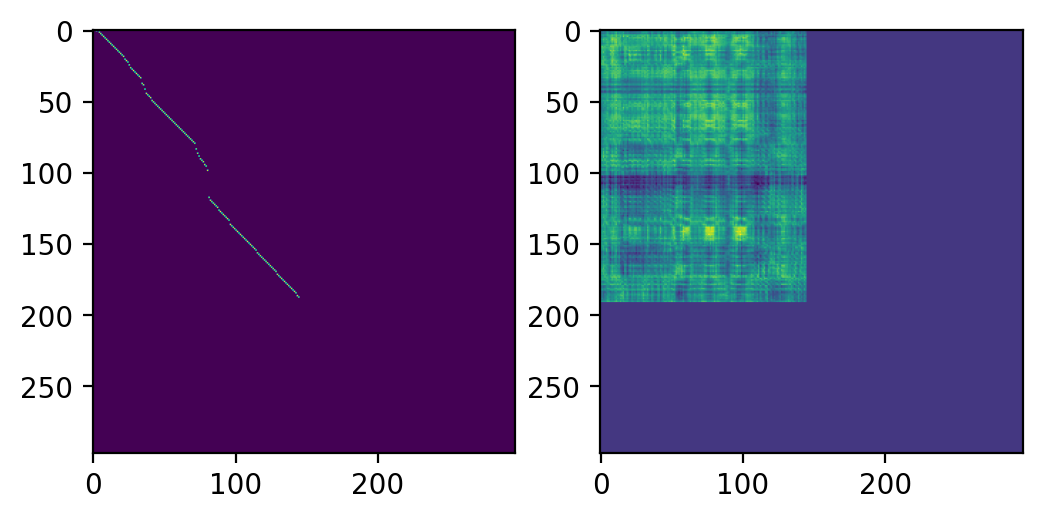

In [30]:
# Example of alignment and similarity matrix
plt.figure(dpi = 200)
plt.subplot(121)
plt.imshow(aln_[1])
plt.subplot(122)
plt.imshow(sim[1])

In [31]:
for k in lddt_scores.keys():
  if  lddt_scores[k]>0.5:
    print(k)

('1A1XA', '1A1XA')
('1A3AA', '1A3AA')
('1A62A', '1A62A')
('1A73A', '1A73A')
('1A8LA', '1A8LA')
('1A92A', '1A92A')
('1A92A', '1RKTA')
('1A92A', '1SD4A')
('1ABAA', '1ABAA')
('1ABAA', '1T1VA')
('1ACFA', '1ACFA')
('1BDBA', '1BDBA')
('1BDBA', '1OAAA')
('1BDBA', '1SBYA')
('1BDBA', '1SNYA')
('1BRTA', '1BRTA')
('1BRTA', '1J1IA')
('1BRTA', '1MJ5A')
('1BRTA', '1MTZA')
('1BRTA', '1Q0RA')
('1BTKA', '1BTKA')
('1BTNA', '1BTNA')
('1BTNA', '1FAOA')
('1C75A', '1C75A')
('1CC8A', '1CC8A')
('1CHDA', '1CHDA')
('1D2ZA', '1D2ZA')
('1D2ZA', '1D2ZB')
('1D2ZB', '1D2ZB')
('1E0CA', '1E0CA')
('1E0CA', '1RHSA')
('1ECSA', '1ECSA')
('1ECSA', '1SS4A')
('1EJ8A', '1EJ8A')
('1EJ8A', '1PZSA')
('1EOKA', '1EOKA')
('1EQ2A', '1EQ2A')
('1EW0A', '1EW0A')
('1FAOA', '1BTKA')
('1FAOA', '1BTNA')
('1FAOA', '1FAOA')
('1FJ2A', '1FJ2A')
('1G8AA', '1G8AA')
('1GS5A', '1GS5A')
('1GV9A', '1GV9A')
('1HDOA', '1BDBA')
('1HDOA', '1HDOA')
('1HDOA', '1SBYA')
('1HZTA', '1HZTA')
('1I1QB', '1I1QB')
('1I1QB', '1O1YA')
('1I27A', '1I27A')
('1I27A', '1

Text(0.5, 0, 'LDDT scores')

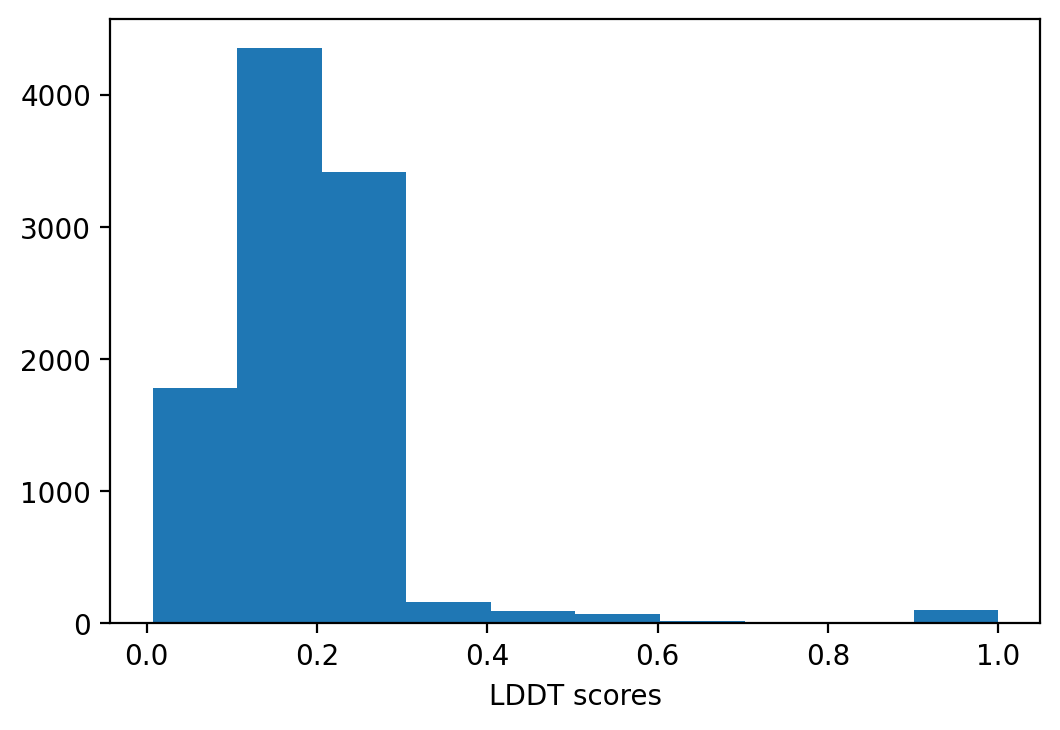

In [32]:
plt.figure(dpi = 200)
plt.hist(lddt_scores.values())
plt.xlabel("LDDT scores")